#SAM to medical images

in questo colab applichiamo il modello SAM a immagini mediche.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
using_colab = True

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: False
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-arq5row6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-arq5row6
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=51ca7b64c04cd236177f8ed306e8e789ca8c8ff17c0db71664be0c0cf6e0e138
  Stored in directory: /tmp/pip-ephem-wheel-cache-y9v_pg3g/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-04-02 06:57:39--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.co

In [4]:
# Visualisation of merged masks
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True) #ordina le maschere per ordine di area
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4)) #crea immagine RGBA trasparente
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]]) #colore casuale per ogni maschera più trasparenza
        img[m] = color_mask
    ax.imshow(img)

# Visualisation of merged Masks' id
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage import center_of_mass

def show_anns_with_ids(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True) #ordina le maschere per ordine di area
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4)) #crea immagine RGBA trasparente
    img[:,:,3] = 0

    np.random.seed(42)  # For reproducibility of colors
    for ann in sorted_anns:
        idx = ann['id']
        m = ann['segmentation']
        color = np.random.rand(3)
        color_mask = np.concatenate([color, [0.35]])
        img[m] = color_mask

        # Trova il centroide e sposta il testo accanto
        cy, cx = center_of_mass(m)
        text_offset_x = 10  # distanza a destra del centroide
        text_offset_y = 0   # nessuno spostamento verticale

        ax.text(cx + text_offset_x, cy + text_offset_y, str(idx), fontsize=8,
                color='white', ha='left', va='center')

    ax.imshow(img)

In [6]:
image = cv2.imread('/content/ID_1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

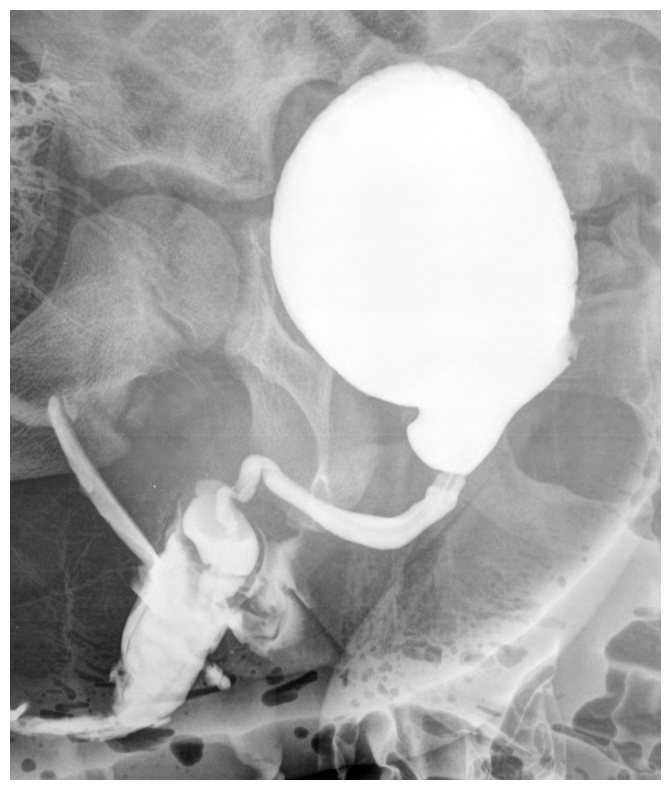

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()



---



---

nel caso di utilizzo pickle


---



---




Real Masks Loaded: 46


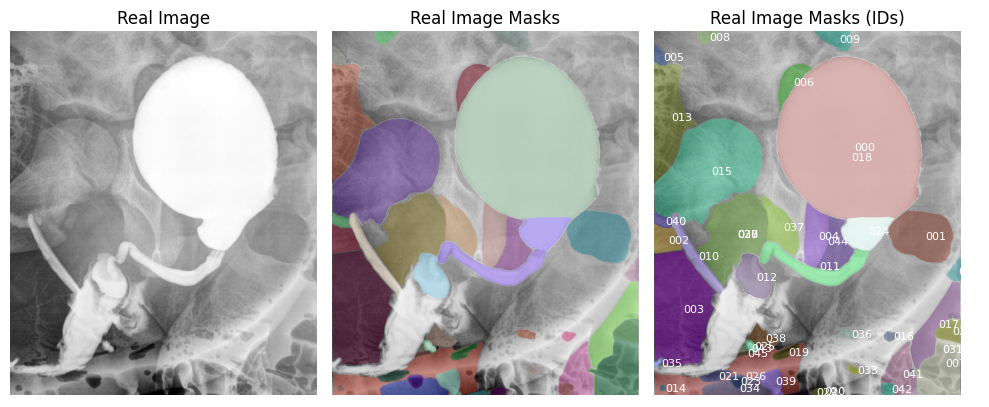

In [ ]:
# Import del pkl se già ne possiedi uno
import pickle
with open('/content/masks_id1_raw.pkl', 'rb') as f:
    masks = pickle.load(f)

print(f"Real Masks Loaded: {len(masks)}")

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
# Plot: Real Image
plt.sca(axs[0])
axs[0].imshow(image)
axs[0].set_axis_off()
axs[0].set_title("Real Image")

# Plot: Real Image and Masks
plt.sca(axs[1])
axs[1].imshow(image)
show_anns(masks)
axs[1].set_axis_off()
axs[1].set_title("Merged Masks")

# Plot: Real Image, Masks and IDs
plt.sca(axs[2])
axs[2].imshow(image)
show_anns_with_ids(masks)
axs[2].set_axis_off()
axs[2].set_title("Merged Masks (IDs)")


plt.tight_layout()
plt.show()

In [ ]:
# Copia dell'immagine originale su cui disegnare
image_with_boxes = image.copy()

for mask in masks:
    mask_id = mask["id"]
    x, y, w, h = mask["bbox"]  # Bounding box: x, y, width, height

    # Disegna la bounding box
    cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color=(255, 0, 0), thickness=2)

    # Aggiungi il testo con l'ID sopra la box
    cv2.putText(image_with_boxes, f"ID: {mask_id}", (x, y - 10),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5,
                color=(255, 0, 0), thickness=1)

# Visualizza il risultato
plt.figure(figsize=(10, 10))
plt.imshow(image_with_boxes)
plt.axis('off')
plt.title("Bounding Boxes con ID")
plt.show()



---



---

PEr caricare i generatori di SAM

In [8]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)



---



---
modello default


---



---



aggiungo anche il calcolo della percentuale di area bianca perchè potrebbe essere utilizzato come filtro nelle immagini più ostiche, dato che non abbiamo un valore di area reale (cioè non possiamo stimare le grandeze delle vesciche in cm^2) allora possiamo utilizzare la percentuale di area occupata dalla vescica nell'immagine. logxamente supponendo che la vescica sia sempre più grande di tutti gli altrielementi presenti nell'immagine.

Sono state generate 46 maschere
Le chiavi del dizionario sono dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box', 'id', 'total_area', 'area_percentage'])
None


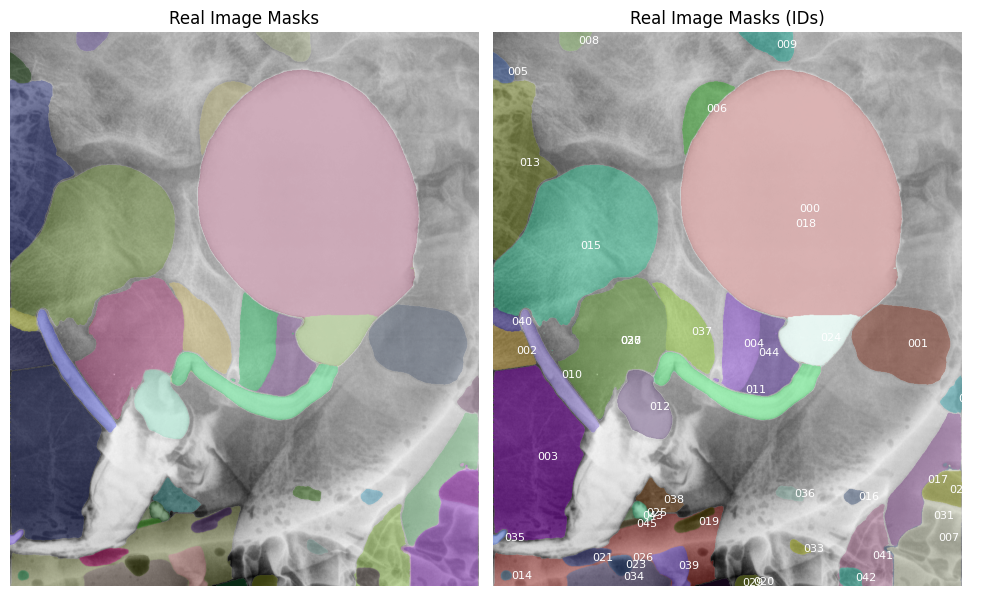

In [9]:
# Modello di default più veloce
masks = mask_generator.generate(image)

print(f"Sono state generate {len(masks)} maschere")

# Aggiunta dell'ID a ciascuna maschera
for i, mask in enumerate(masks):
    mask["id"] = f"{i:03d}"  # formato '000', '001', ..., '999'


# Aggiunta dell'area_percentage a ciascuna maschera
for mask in masks:
    total_area = mask['segmentation'].size
    white_area = mask['area']
    percentage = (white_area / total_area) * 100 if total_area > 0 else 0

    mask['total_area'] = total_area
    mask['area_percentage'] = round(percentage, 3)

print(f"Le chiavi del dizionario sono {masks[0].keys()}")

# Salvataggio pickl di tutte le maschere
import pickle

with open('masks_samdefault_id1_raw.pkl', 'wb') as f: #cambiare il nome in base all'id paziente
    pickle.dump(masks, f)

# Visualisation
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
# Plot: Real Image and Masks
plt.sca(axs[0])
axs[0].imshow(image)
show_anns(masks)
axs[0].set_axis_off()
axs[0].set_title("Real Image Masks")

# Plot: Real Image, Masks and IDs
plt.sca(axs[1])
axs[1].imshow(image)
show_anns_with_ids(masks)
axs[1].set_axis_off()
axs[1].set_title("Real Image Masks (IDs)")


plt.tight_layout()
plt.show()

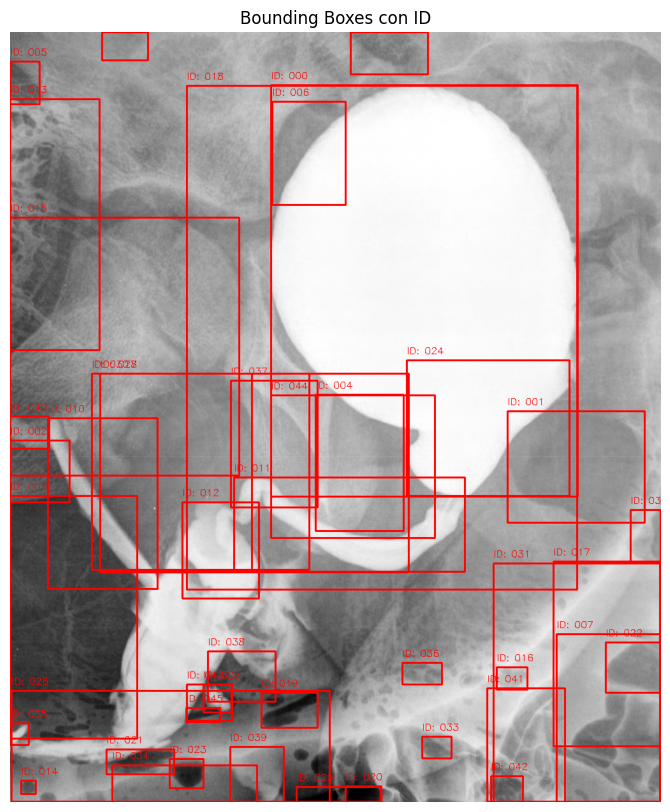

In [10]:
# Copia dell'immagine originale su cui disegnare
image_with_boxes = image.copy()

for mask in masks:
    mask_id = mask["id"]
    x, y, w, h = mask["bbox"]  # Bounding box: x, y, width, height

    # Disegna la bounding box
    cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color=(255, 0, 0), thickness=2)

    # Aggiungi il testo con l'ID sopra la box
    cv2.putText(image_with_boxes, f"ID: {mask_id}", (x, y - 10),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5,
                color=(255, 0, 0), thickness=1)

# Visualizza il risultato
plt.figure(figsize=(10, 10))
plt.imshow(image_with_boxes)
plt.axis('off')
plt.title("Bounding Boxes con ID")
plt.show()



---



---

modello custom


---



---



In [ ]:
# Modello customizzato più lento ma più accurato
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

# Aggiunta dell'ID a ciascuna maschera
for i, mask in enumerate(mask_generator_2):
    mask["id"] = f"{i:03d}"  # formato '000', '001', ..., '999'

print(f"Sono state generate {len(mask_generator_2)} maschere")

# Aggiunta dell'area_percentage a ciascuna maschera
for mask in mask_generator_2:
    total_area = mask_generator_2['segmentation'].size
    white_area = mask_generator_2['area']
    percentage = (white_area / total_area) * 100 if total_area > 0 else 0

    mask_generator_2['total_area'] = total_area
    mask_generator_2['area_percentage'] = round(percentage, 3)

print(print(f"Le chiavi del dizionario sono {mask_generator_2[0].keys()}"))

# Salvataggio pickl di tutte le maschere
import pickle

with open('masks_samcustom_id1_raw.pkl', 'wb') as f: #cambiare il nome in base all'id paziente
    pickle.dump(mask_generator_2, f)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

# Plot: Real Image and Masks
plt.sca(axs[0])
axs[0].imshow(image)
show_anns(mask_generator_2)
axs[0].set_axis_off()
axs[0].set_title("Real Image Masks")

# Plot: Real Image, Masks and IDs
plt.sca(axs[1])
axs[1].imshow(image)
show_anns_with_ids(mask_generator_2)
axs[1].set_axis_off()
axs[1].set_title("Real Image Masks (IDs)")


plt.tight_layout()
plt.show()

In [ ]:
# Copia dell'immagine originale su cui disegnare
image_with_boxes = image.copy()

for mask in mask_generator_2:
    mask_id = mask["id"]
    x, y, w, h = mask["bbox"]  # Bounding box: x, y, width, height

    # Disegna la bounding box
    cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color=(255, 0, 0), thickness=2)

    # Aggiungi il testo con l'ID sopra la box
    cv2.putText(image_with_boxes, f"ID: {mask_id}", (x, y - 10),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5,
                color=(255, 0, 0), thickness=1)

# Visualizza il risultato
plt.figure(figsize=(10, 10))
plt.imshow(image_with_boxes)
plt.axis('off')
plt.title("Bounding Boxes con ID")
plt.show()

#Filtro su Qualità



---



---


**Funzione per filtrare le maschere ottenute dopo la funzione .generate()**


Prende in input la lista di maschere masks generata da SAM.
Applica un filtro basato su:


*  predicted_iou > 0.85
*  stability_score > 0.9



Restituisce solo le maschere che soddisfano entrambi i criteri.



---



---

In [11]:
def filter_high_quality_masks(masks, iou_threshold=0.87, stability_threshold=0.95):
    """
    Filtra le maschere di SAM in base ai valori di predicted_iou e stability_score.

    Args:
        masks (list): Lista di dizionari contenenti le maschere generate da SAM.
        iou_threshold (float): Soglia minima per predicted_iou.
        stability_threshold (float): Soglia minima per stability_score.

    Returns:
        list: Lista delle maschere che superano le soglie di qualità.
    """
    high_quality_masks = [
        mask for mask in masks
        if mask["predicted_iou"] > iou_threshold and mask["stability_score"] > stability_threshold
    ]
    return high_quality_masks

Numero di maschere filtrate: 46


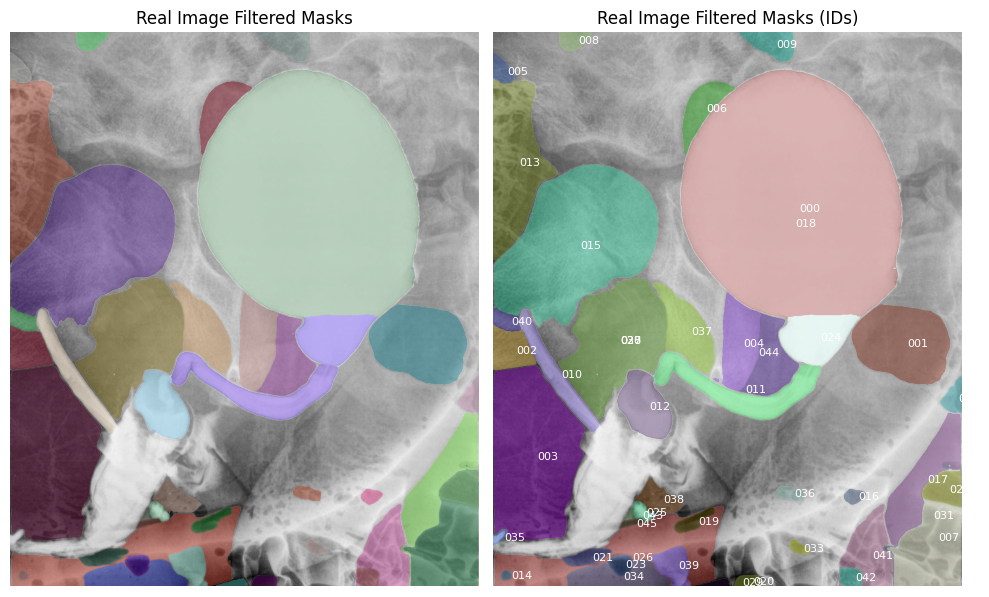

In [12]:
filtered_masks = filter_high_quality_masks(masks) # in caso di utilizzo del modello custom, da modificare con "mask_generator_2"

# Stampa il numero di maschere filtrate
print(f"Numero di maschere filtrate: {len(filtered_masks)}")

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

# Plot: Real Image and Masks
plt.sca(axs[0])
axs[0].imshow(image)
show_anns(filtered_masks)
axs[0].set_axis_off()
axs[0].set_title("Real Image Filtered Masks")

# Plot: Real Image, Masks and IDs
plt.sca(axs[1])
axs[1].imshow(image)
show_anns_with_ids(filtered_masks)
axs[1].set_axis_off()
axs[1].set_title("Real Image Filtered Masks (IDs)")


plt.tight_layout()
plt.show()

#Filtro su misura area

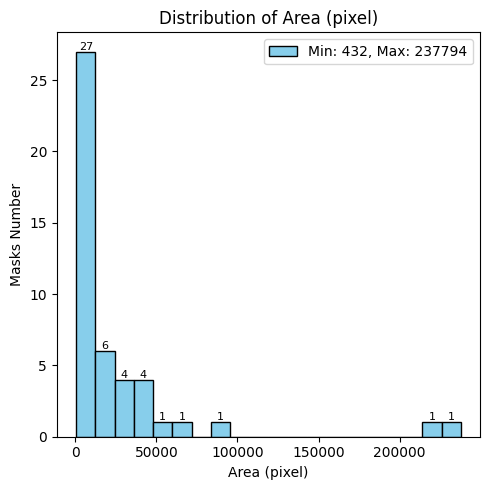

In [13]:
import matplotlib.pyplot as plt

# Dati delle aree
areas_pixel = [mask["area"] for mask in filtered_masks]

# Calcolo min e max
min_pixel, max_pixel = min(areas_pixel), max(areas_pixel)

# Creazione dei subplot
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# --- Istogramma delle aree in pixel ---
counts_pixel, bins_pixel, patches_pixel = axs.hist(areas_pixel, bins=20, color='skyblue', edgecolor='black')
axs.set_xlabel("Area (pixel)")
axs.set_ylabel("Masks Number")
axs.set_title("Distribution of Area (pixel)")
axs.legend([f"Min: {min_pixel}, Max: {max_pixel}"], loc='upper right')

# Aggiunta delle etichette su ogni barra
for count, patch in zip(counts_pixel, patches_pixel):
    if count > 0:
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        axs.text(x, y, int(count), ha='center', va='bottom', fontsize=8)


plt.tight_layout()
plt.show()

In [14]:
def filter_masks_by_area(masks, min_area=50000, max_area=3000000):
    """
    Filtra le maschere in base alla loro area.

    Args:
        masks (list): Lista di dizionari contenenti le maschere generate da SAM.
        min_area (int): Soglia minima dell'area della maschera (in pixel).
        max_area (int): Soglia massima dell'area della maschera (in pixel).

    Returns:
        list: Lista delle maschere che rientrano nel range di area specificato.
    """
    filtered_masks = [
        mask for mask in masks
        if min_area <= mask["area"] <= max_area
    ]
    return filtered_masks

In [15]:
# Set max and min area
max_area=max_pixel
min_area=max_pixel/2

# Filtro per grandezza area pixel
filtered_area_masks = filter_masks_by_area(masks, min_area, max_pixel)

# Stampa il numero di maschere rimaste dopo il filtro per area
print(f"Maschere dopo il filtro per area: {len(filtered_area_masks)}")

Maschere dopo il filtro per area: 2


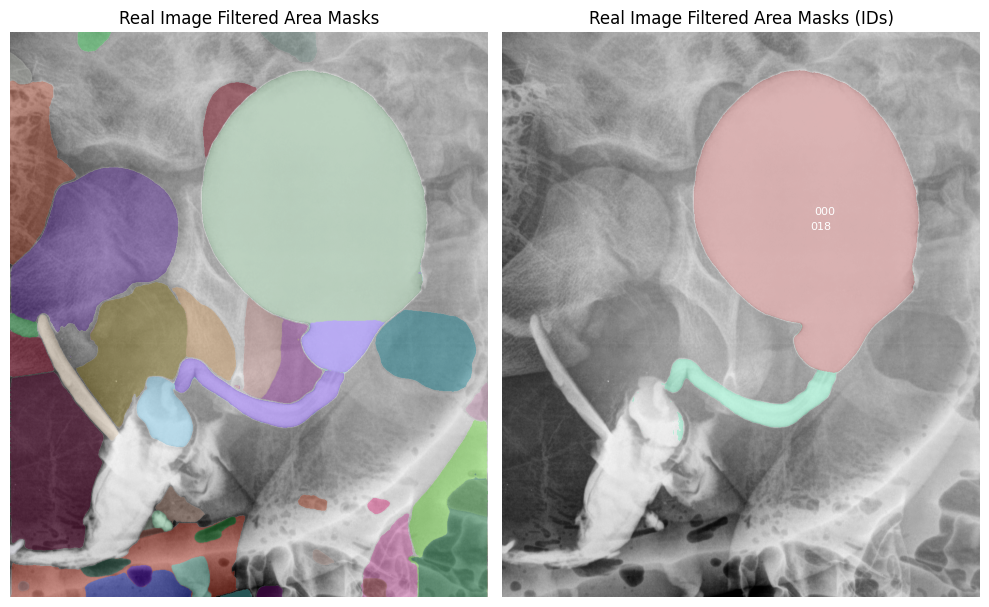

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

# Plot: Real Image and Masks
plt.sca(axs[0])
axs[0].imshow(image)
show_anns(filtered_masks)
axs[0].set_axis_off()
axs[0].set_title("Real Image Filtered Area Masks")

# Plot: Real Image, Masks and IDs
plt.sca(axs[1])
axs[1].imshow(image)
show_anns_with_ids(filtered_area_masks)
axs[1].set_axis_off()
axs[1].set_title("Real Image Filtered Area Masks (IDs)")


plt.tight_layout()
plt.show()

#Filtro Roundness

In [17]:
import numpy as np
import cv2

def compute_roundness(mask):
    """
    Compute the roundness of the white region in a binary mask.
    """
    # Convert boolean mask to uint8 (0 and 255)
    mask = mask.astype(np.uint8) * 255
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None  # No object found

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_contour)
    perimeter = cv2.arcLength(largest_contour, True)

    if perimeter == 0:
        return None  # Avoid division by zero

    roundness = (4 * np.pi * area) / (perimeter ** 2)
    return roundness

def add_roundness_to_masks(masks):
    """
    Adds the computed roundness to each mask dictionary entry in masks.
    """
    for mask_entry in masks:
        mask = mask_entry['segmentation']  # Assuming this is a numpy array
        roundness = compute_roundness(mask)
        mask_entry['roundness'] = roundness  # Store roundness in the dictionary

    return masks

Maschere dopo il filtro per roundness: 2


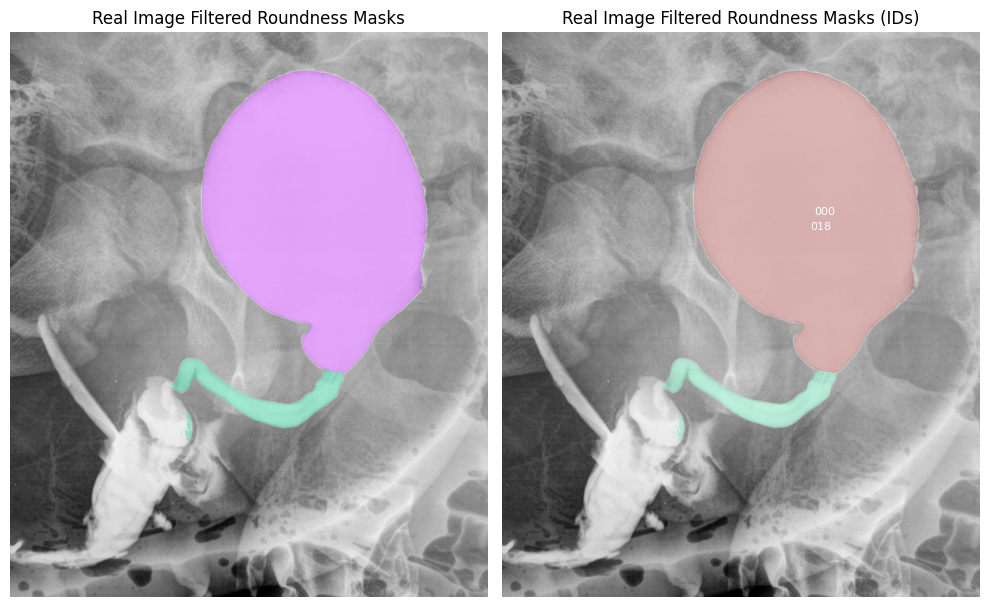

In [18]:
roundeness_masks = add_roundness_to_masks(filtered_area_masks)

# Stampa il numero di maschere rimaste dopo il filtro per reoundness
print(f"Maschere dopo il filtro per roundness: {len(roundeness_masks)}")

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

# Plot: Real Image and Masks
plt.sca(axs[0])
axs[0].imshow(image)
show_anns(roundeness_masks)
axs[0].set_axis_off()
axs[0].set_title("Real Image Filtered Roundness Masks")

# Plot: Real Image, Masks and IDs
plt.sca(axs[1])
axs[1].imshow(image)
show_anns_with_ids(roundeness_masks)
axs[1].set_axis_off()
axs[1].set_title("Real Image Filtered Roundness Masks (IDs)")


plt.tight_layout()
plt.show()

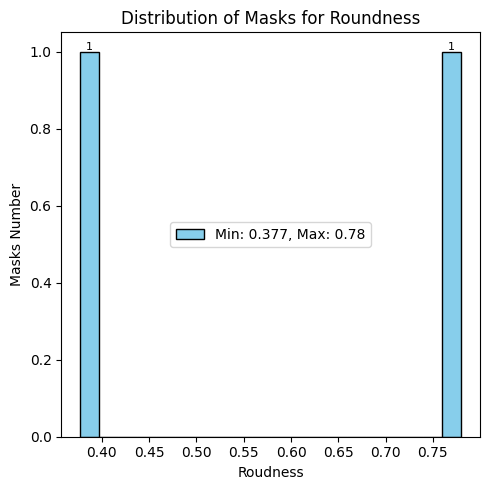

In [19]:
import matplotlib.pyplot as plt

# Dati delle aree
roundness = [mask["roundness"] for mask in filtered_area_masks]

# Calcolo min e max
min_roundness, max_roundness = round(min(roundness),3), round(max(roundness), 3)

# Creazione dei subplot
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# --- Istogramma delle aree in pixel ---
counts, bins, patches = axs.hist(roundness, bins=20, color='skyblue', edgecolor='black')
axs.set_xlabel("Roudness")
axs.set_ylabel("Masks Number")
axs.set_title("Distribution of Masks for Roundness")
axs.legend([f"Min: {min_roundness}, Max: {max_roundness}"], loc='center')

# Aggiunta delle etichette su ogni barra
for count, patch in zip(counts, patches):
    if count > 0:
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        axs.text(x, y, int(count), ha='center', va='bottom', fontsize=8)


plt.tight_layout()
plt.show()



---



---

save pkl after filter


---



---



In [20]:
import pickle

with open('masks_samdefault_id1_roundness_filtered.pkl', 'wb') as f:
    pickle.dump(roundeness_masks, f)

#Aiutante-Etichettatore



1.   Chiede l'ID del paziente.
2.   Chiede se usare maschere default o filtrate.
3. Per ogni maschera, mostra l’immagine con overlay della maschera.
4. Permette all’utente di scegliere l’etichetta (1-4:1 per vescica, 2 per uretra, 3 vescica_and_uretra, 4 per other).
5. Salva tutte le informazioni in un CSV.








In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import numpy as np
import pickle
from IPython.display import clear_output

# Dizionario delle etichette
label_dict = {
    '1': 'vescica',
    '2': 'uretra',
    '3': 'vescica_and_uretra',
    '4': 'other'
}

def overlay_mask_on_image(image, mask, alpha=0.5):
    """Sovrappone una maschera (binary) all'immagine originale con trasparenza."""
    color_mask = np.zeros_like(image)
    color_mask[mask == 1] = [255, 0, 0]  # Rosso per maschere
    return cv2.addWeighted(image, 1, color_mask, alpha, 0)

def labeling_helper(use_filtered=False):
    image_name = input("Inserisci l'id del paziente: ").upper()
    image_path = image_name + ".png"  # o .jpg se serve
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    is_pathologic = input("Il paziente è patologico? (s/n): ").lower() == 's'
    use_filtered = input("Usare maschere filtrate? (s/n): ").lower() == 's'

    if use_filtered:
        pkl_path = '/content/masks_samdefault_id1_roundness_filtered.pkl'
    else:
      pkl_path = '/content/masks_id1_raw.pkl'

    with open(pkl_path, 'rb') as f:
          masks = pickle.load(f)

    results = []

    for mask in masks:
        print("Etichette disponibili: 1-vescica, 2-uretra, 3-vescica_and_uretra, 4-other")
        mask_id = mask["id"]
        binary_mask = mask["segmentation"]
        overlay = overlay_mask_on_image(image.copy(), binary_mask)

        plt.imshow(overlay)
        plt.title(f"Mask ID: {mask_id}")
        plt.axis('off')
        plt.show()
        plt.close()

        plt.pause(0.1)

        label_id = input("Inserisci etichetta (1-4): ")
        label = label_dict.get(label_id, 'other')

        row = {
            "image_id": image_name,
            "is_pathologic": is_pathologic,
            "mask_id": mask_id,
            "label_id": label_id,
            "label": label
        }

        # Aggiungiamo tutte le altre chiavi della maschera
        for k, v in mask.items():
            if k not in row:
                row[k] = v

        results.append(row)
        clear_output(wait=True)

    # Salva in CSV
    df = pd.DataFrame(results)
    output_csv = f'{image_name}_annotation.csv'
    df.to_csv(output_csv, index=False)

    print(f"Etichettatura completata e salvata in {output_csv}")

In [67]:
labeling_helper()

Etichettatura completata e salvata in ID_1_annotation.csv
